https://gis.stackexchange.com/questions/350771/earth-engine-simplest-way-to-move-from-ee-image-to-array-for-use-in-sklearn

### Setup

#### Install GEE API

In [1]:
!pip install -U earthengine-api

Requirement already up-to-date: earthengine-api in /env/lib/python3.6/site-packages (0.1.242)


#### Import modules

In [2]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import sys
import folium
import datacube

sys.path.append("../Scripts")

In [3]:
dc = datacube.Datacube(app='WCF')

#### Authenticate

In [4]:
#ee.Authenticate()

In [5]:
ee.Initialize()

### Define parameters 

In [6]:
# Define parameters

# Dates
# NOTE: GEE dates are inclusive and GA are exclusive on the end date
start = '2018-01-01'
end_ga = '2018-12-31'
end_gee = '2019-01-01'

# Set the central latitude and longitude
central_lat = -35.555439 
central_lon = 138.886889

In [7]:
# Set the buffer to load around the central coordinates
buffer = 0.05 # must be small for .sampleRectangle() to work

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

### Load GEE imagery

In [8]:
# Define an area of interest.
aoi = ee.Geometry.Polygon(
  [[[study_area_lon[0], study_area_lat[0]],
    [study_area_lon[0], study_area_lat[1]],
    [study_area_lon[1], study_area_lat[1]],
    [study_area_lon[1], study_area_lat[0]]]], None, False)

# Filter collection to get desired image
img = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")\
        .filterBounds(aoi)\
        .filterDate(start,end_gee)\
        .filter(ee.Filter.lt('CLOUD_COVER',5))\
        .select(['B4', 'B3', 'B2'])\
        .first()\

### Convert image into a numpy array

In [9]:
# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
band_arrs = img.sampleRectangle(region=aoi)

# Get individual band arrays.
band_arr_b4 = band_arrs.get('B2') #B2
band_arr_b5 = band_arrs.get('B3') #B3
band_arr_b6 = band_arrs.get('B4') #B4

# Transfer the arrays from server to client and cast as np array.
np_arr_b4 = np.array(band_arr_b4.getInfo())
np_arr_b5 = np.array(band_arr_b5.getInfo())
np_arr_b6 = np.array(band_arr_b6.getInfo())
print(np_arr_b4.shape)
print(np_arr_b5.shape)
print(np_arr_b6.shape)

# Expand the dimensions of the images so they can be concatenated into 3-D.
np_arr_b4 = np.expand_dims(np_arr_b4, 2)
np_arr_b5 = np.expand_dims(np_arr_b5, 2)
np_arr_b6 = np.expand_dims(np_arr_b6, 2)
print(np_arr_b4.shape)
print(np_arr_b5.shape)
print(np_arr_b6.shape)

# Stack the individual bands to make a 3-D array.
rgb_img = np.concatenate((np_arr_b6, np_arr_b5, np_arr_b4), 2)
print(rgb_img.shape)

(377, 311)
(377, 311)
(377, 311)
(377, 311, 1)
(377, 311, 1)
(377, 311, 1)
(377, 311, 3)


### Display new numpy array

In [10]:
# Scale the data to [0, 255] to show as an RGB image.
rgb_img_test = (255*((rgb_img - 100)/3000)).astype('uint8')

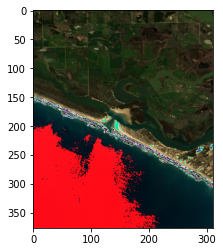

In [11]:
plt.imshow(rgb_img_test)
plt.show()

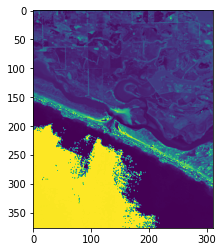

In [12]:
plt.imshow(rgb_img_test[:,:,0])
plt.show()

### Load GA data

In [13]:
#Load all data in baseline period available from Near Real Time data
wofs = dc.load(
              product=['wofs_annual_summary'],
              x= study_area_lon,
              y= study_area_lat,
              time=(start, end_ga),
              output_crs='EPSG:4326',
              resolution=(-0.00026525198938992045,0.0003215434083601286),
              resampling='cubic'
)

In [14]:
wofs

<xarray.Dataset>
Dimensions:      (latitude: 378, longitude: 312, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01
  * latitude     (latitude) float64 -35.51 -35.51 -35.51 ... -35.6 -35.61 -35.61
  * longitude    (longitude) float64 138.8 138.8 138.8 ... 138.9 138.9 138.9
    spatial_ref  int32 4326
Data variables:
    count_wet    (time, latitude, longitude) int16 0 0 0 0 0 ... 14 14 13 13 13
    count_clear  (time, latitude, longitude) int16 18 18 18 18 ... 14 13 13 13
    frequency    (time, latitude, longitude) float32 0.0 0.0 0.0 ... 1.0 1.0 1.0
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

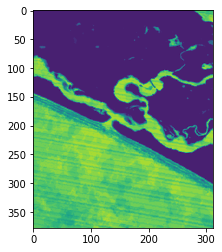

In [15]:
plt.imshow(np.array(wofs['count_wet'][0,:,:]))
plt.show()

Text(0.5, 1.0, 'GEE Satellite Imagery')

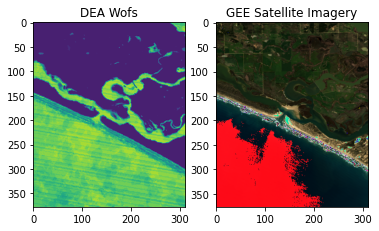

In [16]:
f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np.array(wofs['count_wet'][0,:,:]))
ax1.set_title('DEA Wofs')
ax2.imshow(rgb_img_test)
ax2.set_title('GEE Satellite Imagery')